# Cyber Security Analysis
#### This project analyzes a Kaggle dataset titled, [Global Cybersecurity Threats (2015-2024).](https://www.kaggle.com/datasets/atharvasoundankar/global-cybersecurity-threats-2015-2024)

#### This project examines over 3,000 cyber security incidents over a ten-year period, examining features such as:

- **The country where the incident occurred.**
- **The year that when the incident occurred.**
- **The type of attack, such as Malware or DDoS.**
- **The method of attack, such as Phishing or SQL Injection.**
- **The estimated amount of money that the victim had to pay to recover from the incident (in millions).**
- **The response time to resolve the incident.**

#### This project aims to examine descriptive statistics about cyber security incidents, test different Machine Learning (ML)-based methods on predicting the financial impacts of future cyber security incidents, and learn which factors are most likely to increase that impact.

#### The different ML-based tools being utilized are:

- **Sci-Kit Learn**
- **Tensorflow**
- **PyTorch**
- **XGBoost**

# Importing Modules

In [18]:
import keras_tuner as kt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Data Loading

In [20]:
df = pd.read_csv('Global_Cybersecurity_Threats_2015-2024.csv')

In [21]:
df.head()

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


# Cybersecurity Incidents Per Country

#### This chart shows that cybersecurity incidents are relatively uniform across most countries in our sample, but seem to be striking UK most.

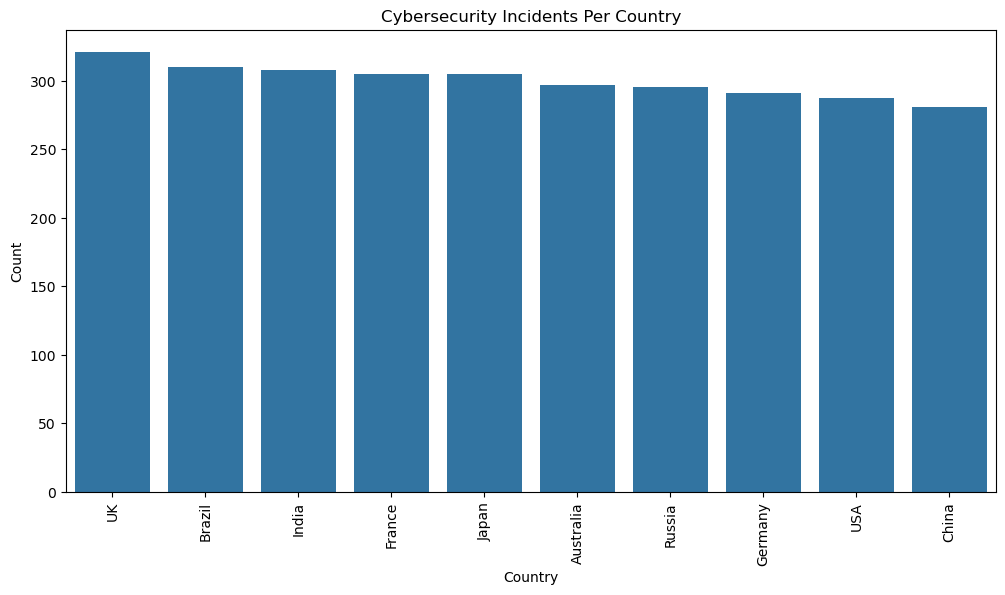

In [24]:
country_counts = df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Count']
plt.figure(figsize=(12,6))
sns.barplot(data=country_counts, x='Country', y='Count')
plt.xticks(rotation=90)
plt.title("Cybersecurity Incidents Per Country")
plt.show()

# Cybersecurity Incidents Per Year

#### This chart shows that despite a drop in 2019, there is an increase in the amount of incidents. On average, there are over 2.5 million cyber security incidents each year.

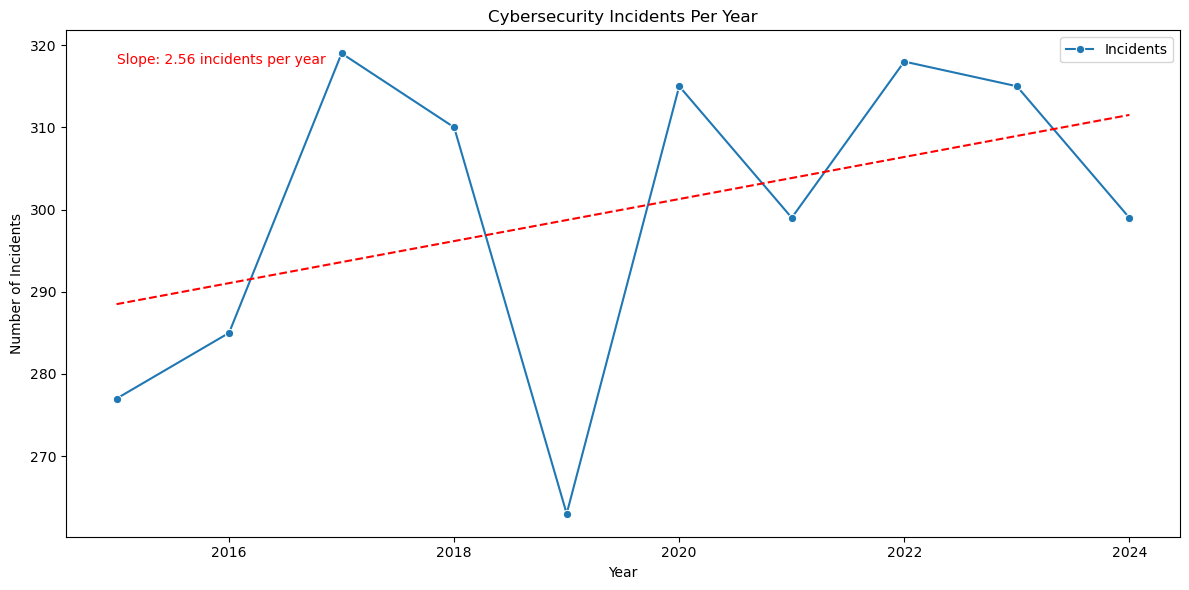

In [27]:
year_counts = df['Year'].value_counts().sort_index().reset_index()
year_counts.columns = ['Year', 'Count']

plt.figure(figsize=(12,6))

# Line plot of incidents
sns.lineplot(data=year_counts, x='Year', y='Count', marker='o', label='Incidents')

# Fit linear regression
z = np.polyfit(year_counts['Year'], year_counts['Count'], 1)
p = np.poly1d(z)
plt.plot(year_counts['Year'], p(year_counts['Year']), 'r--', label='Trend Line')

# Annotate slope
slope = z[0]
plt.text(x=year_counts['Year'].min(), y=year_counts['Count'].max(), s=f"Slope: {slope:.2f} incidents per year", color='red', fontsize=10, ha='left',
         va='top')

# Final touches
plt.ylabel("Number of Incidents")
plt.title("Cybersecurity Incidents Per Year")
plt.tight_layout()
plt.show()

# Affected Users Per Year

#### This chart shows that despite a drop in 2019, there is a similar increase in the amount of incidents as there is to the number of incidents. On average, 1.36 million users are affected by cyber security incidents each year.

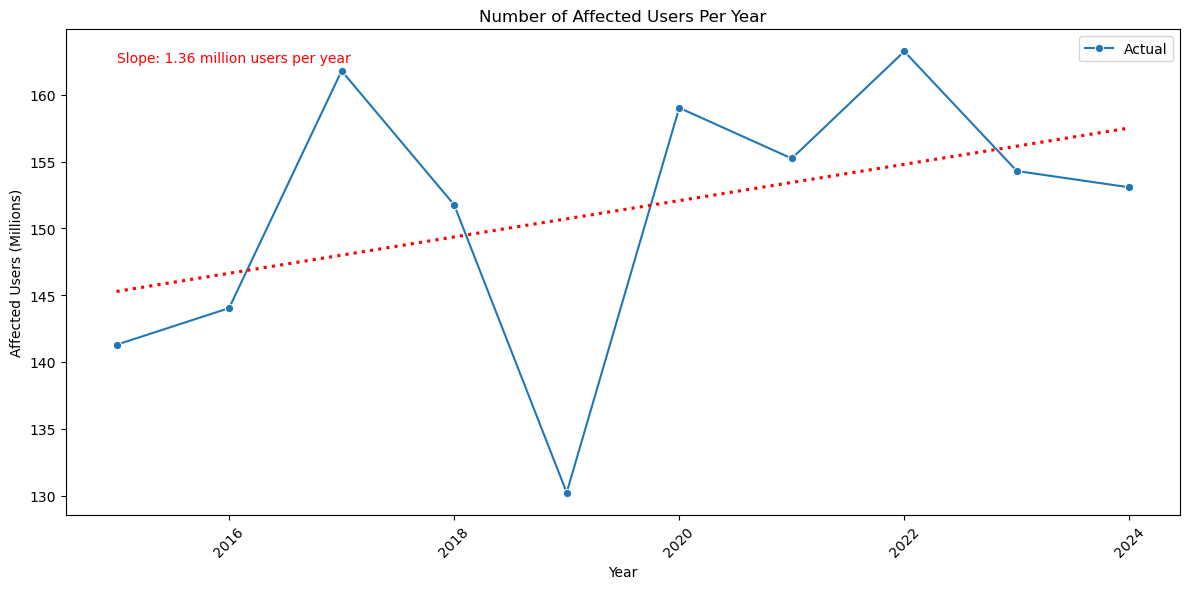

In [30]:
yearly_users = df.groupby('Year')['Number of Affected Users'].sum().reset_index()
yearly_users = yearly_users.sort_values('Year')
yearly_users['Users (Millions)'] = yearly_users['Number of Affected Users'] / 1_000_000

# Plot the actual data
plt.figure(figsize=(12,6))
sns.lineplot(data=yearly_users, x='Year', y='Users (Millions)', marker='o', label='Actual')

# Add dotted regression line
sns.regplot(data=yearly_users, x='Year', y='Users (Millions)', scatter=False, ci=None,
            line_kws={'linestyle': 'dotted', 'color': 'red', 'label': 'Trend'})

# Fit linear regression manually to get slope
z = np.polyfit(yearly_users['Year'], yearly_users['Users (Millions)'], 1)
slope = z[0]

# Annotate slope on the plot
plt.text(x=yearly_users['Year'].min(), y=yearly_users['Users (Millions)'].max(), s=f"Slope: {slope:.2f} million users per year", color='red',
         fontsize=10, ha='left', va='top')

# Customize plot
plt.title("Number of Affected Users Per Year")
plt.ylabel("Affected Users (Millions)")
plt.xticks(rotation=45)

# Disable scientific notation
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# Financial Loss Per Year

#### This chart shows that despite a drop in 2019, there is a similar increase in the amount of incidents as there is to the number of incidents. On average, incidents cost over $160 million more each year.

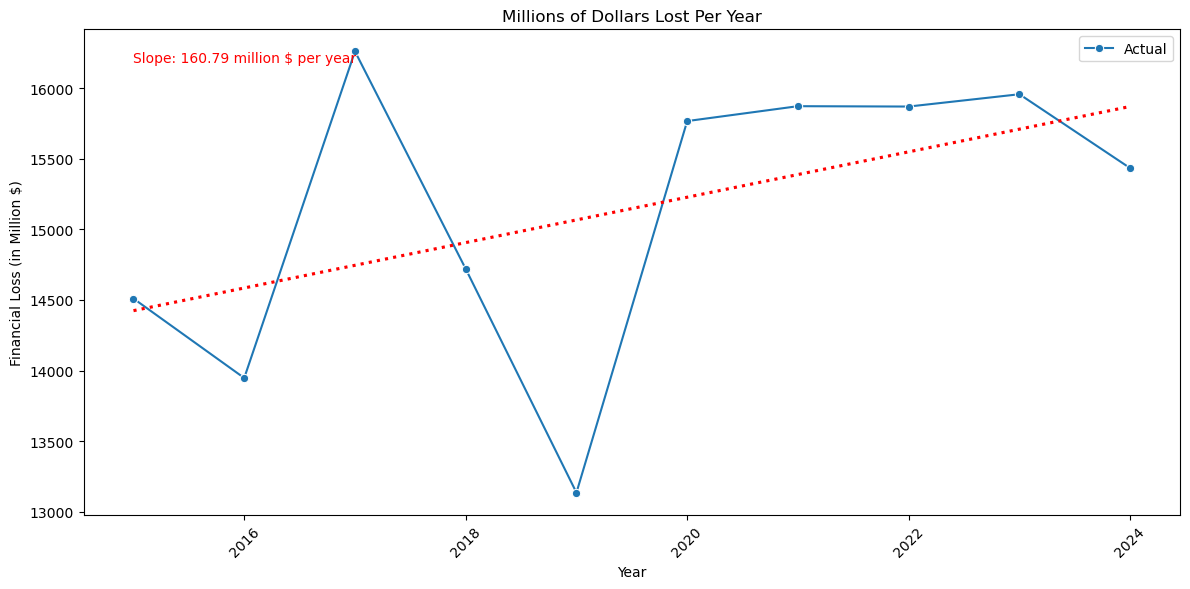

In [33]:
financial_loss_year = df.groupby("Year")["Financial Loss (in Million $)"].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=financial_loss_year, x='Year', y='Financial Loss (in Million $)', marker='o', label='Actual')

# Add dotted regression line
sns.regplot(data=financial_loss_year, x='Year', y='Financial Loss (in Million $)', scatter=False, ci=None,
            line_kws={'linestyle': 'dotted', 'color': 'red', 'label': 'Trend'})

# Fit linear regression manually to get slope
z = np.polyfit(financial_loss_year['Year'], financial_loss_year['Financial Loss (in Million $)'], 1)
slope = z[0]

# Annotate slope on the plot
plt.text(x=financial_loss_year['Year'].min(), y=financial_loss_year['Financial Loss (in Million $)'].max(),
         s=f"Slope: {slope:.2f} million $ per year",    color='red', fontsize=10, ha='left', va='top')

# Customize plot
plt.title("Millions of Dollars Lost Per Year")
plt.xticks(rotation=45)

# Disable scientific notation
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# Target Industry Composition

#### This chart shows that near uniform distribution regarding the target industry.

Text(0, 0.5, '')

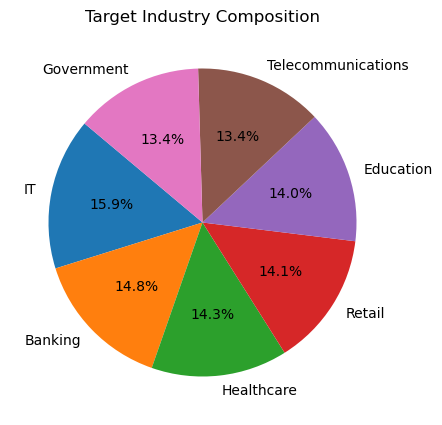

In [36]:
industry_counts = df['Target Industry'].value_counts()
industry_counts.plot.pie(figsize=(5,5), autopct='%1.1f%%', startangle=140)
plt.title("Target Industry Composition")
plt.ylabel("")

# Attack Type Composition

#### This chart shows that near uniform distribution regarding the type of attack used.

Text(0, 0.5, '')

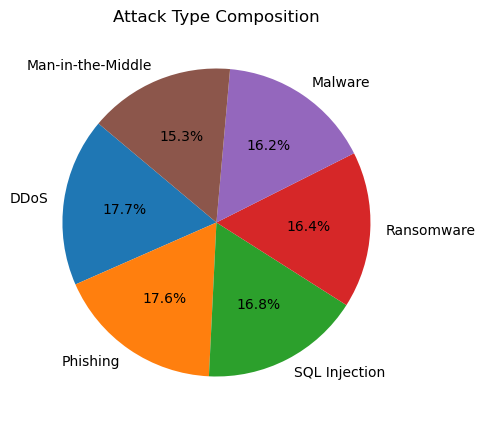

In [39]:
attack_counts = df['Attack Type'].value_counts()
attack_counts.plot.pie(figsize=(5,5), autopct='%1.1f%%', startangle=140)
plt.title("Attack Type Composition")
plt.ylabel("")

# Attack Source Composition

#### This chart shows that no clear attack source is responsible for most of the cyber security incidents.

Text(0, 0.5, '')

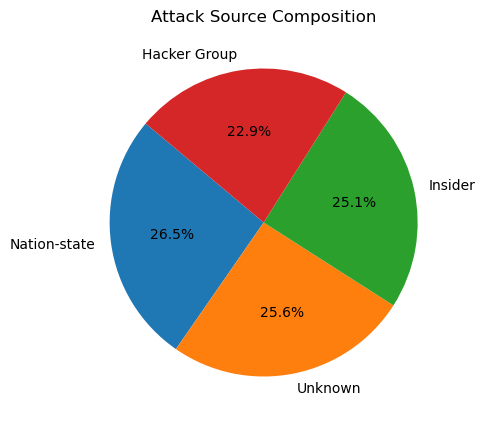

In [42]:
attack_source_counts = df['Attack Source'].value_counts()
attack_source_counts.plot.pie(figsize=(5,5), autopct='%1.1f%%', startangle=140)
plt.title("Attack Source Composition")
plt.ylabel("")

# Security Vulnerability Type Composition

#### This chart shows that near uniform distribution for the security vulnerability of the victims.

Text(0, 0.5, '')

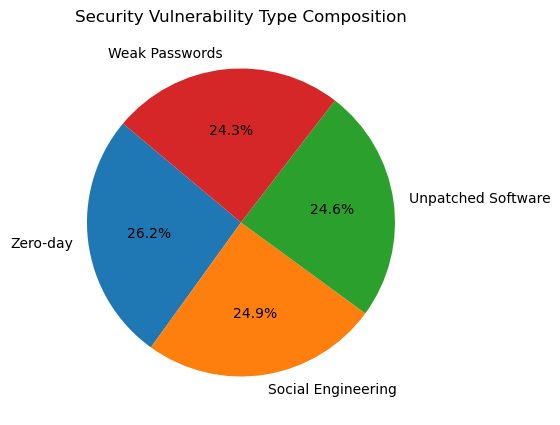

In [45]:
vulnerability_counts = df['Security Vulnerability Type'].value_counts()
vulnerability_counts.plot.pie(figsize=(5,5), autopct='%1.1f%%', startangle=140)
plt.title("Security Vulnerability Type Composition")
plt.ylabel("")

# Defense Mechanism Used Composition

#### This chart shows that near uniform distribution for the defense mechanism used by each victim.

Text(0, 0.5, '')

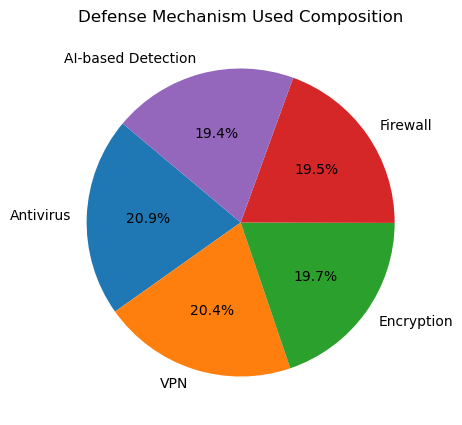

In [48]:
defense_mech = df['Defense Mechanism Used'].value_counts()
defense_mech.plot.pie(figsize=(5,5), autopct='%1.1f%%', startangle=140)
plt.title("Defense Mechanism Used Composition")
plt.ylabel("")

# Incident Resolution Time Analysis

#### This chart shows a a decreasing timeline for incident incidents, averaging a half an hour quicker response each year.

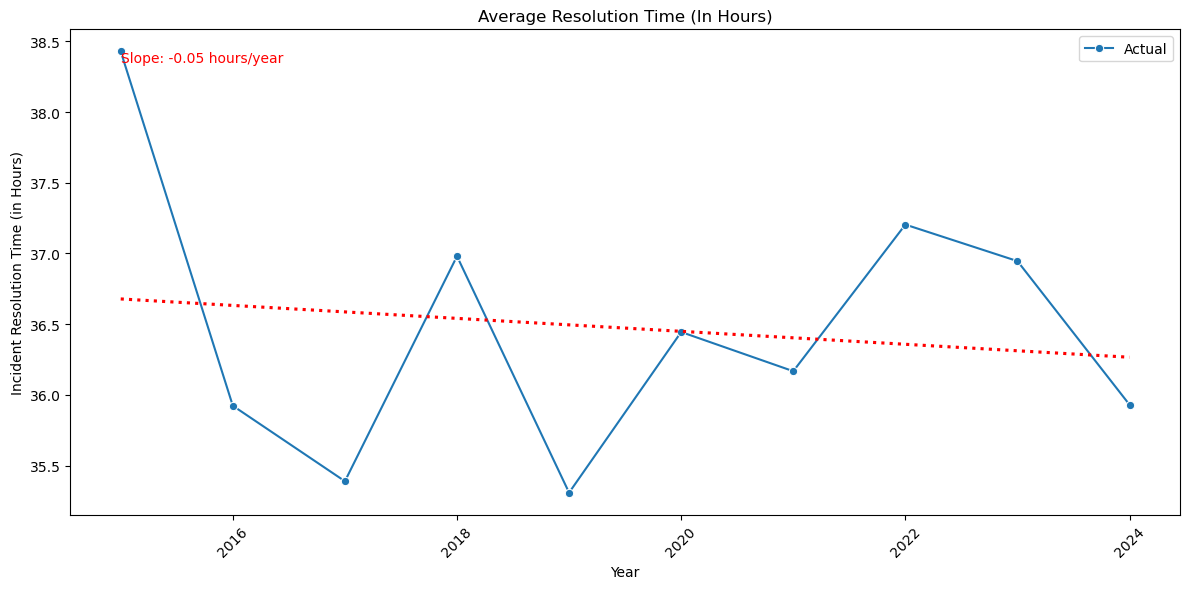

In [51]:
resolution_by_year = df.groupby('Year')['Incident Resolution Time (in Hours)'].mean().reset_index()
resolution_by_year = resolution_by_year.sort_values('Year')

# Plot the actual data
plt.figure(figsize=(12,6))
sns.lineplot(data=resolution_by_year, x='Year', y='Incident Resolution Time (in Hours)', marker='o', label='Actual')

# Add dotted regression line
sns.regplot(data=resolution_by_year, x='Year', y='Incident Resolution Time (in Hours)', scatter=False, ci=None,
            line_kws={'linestyle': 'dotted', 'color': 'red', 'label': 'Trend'})

# Fit linear regression manually to get slope
z = np.polyfit(resolution_by_year['Year'], resolution_by_year['Incident Resolution Time (in Hours)'], 1)
slope = z[0]

# Annotate slope on the plot
plt.text(x=resolution_by_year['Year'].min(), y=resolution_by_year['Incident Resolution Time (in Hours)'].max(), s=f"Slope: {slope:.2f} hours/year",
         color='red', fontsize=10, ha='left', va='top')

# Customize plot
plt.title("Average Resolution Time (In Hours)")
plt.xticks(rotation=45)

# Disable scientific notation
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

# Data Preparation for Machine Learning

#### These cells prepare the df to be ready for ML-deployment.

In [54]:
#Creating an affected users variable to treat outliers.
df['Financial Loss (in Million $)_Log'] = np.log1p(df['Financial Loss (in Million $)'])

# Example: Remove non-feature columns
X = df.drop(columns=["Financial Loss (in Million $)", "Financial Loss (in Million $)_Log"])
y = df["Financial Loss (in Million $)"]

#Creating a list of numeric and categorical features.
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [55]:
#Inputting missing values.

#Replacing missing values with the mean.
numeric_transformer = Pipeline([("imputer", SimpleImputer(strategy="mean")),("scaler", StandardScaler())])

#Replacing missing values with the most frequentr value.
categorical_transformer = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))])

#Transforming the transformers into a numerical matrix.
preprocessor = ColumnTransformer([("num", numeric_transformer, numeric_features),("cat", categorical_transformer, categorical_features)])

## Sci-Kit Learn

#### Sci-Kit Learn uses Random Forest techniques to process the information to provide a MAE of 20.02 and an R-Squared value of 0.35.

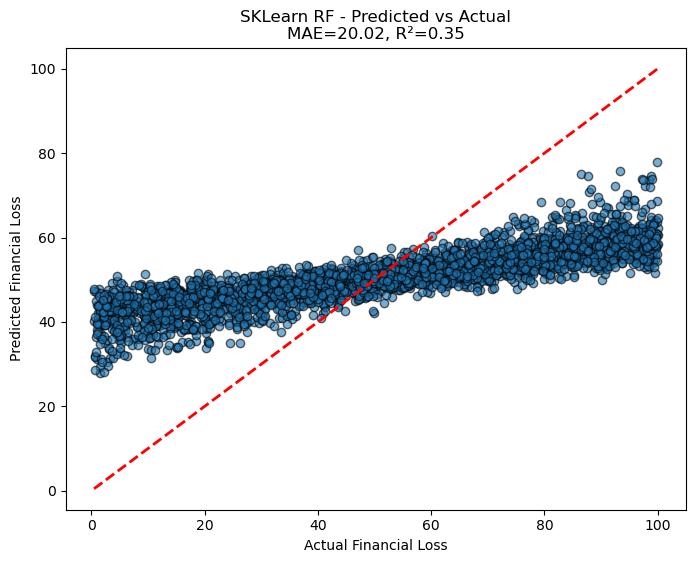

In [58]:
# This calculates the Mean Absolute Error and the R-Squared score on the predictive model.
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, r2

#Creates a random forest regressor.
sk_model = RandomForestRegressor(random_state=42)

#Examines the amount of trees and its depth for each tree when running the random forest regressor.
param_grid = {"model__n_estimators": [100, 200], "model__max_depth": [None, 10, 20]}

#Preprocesses and fits the pipeline model of the random regression model.
sk_pipeline = Pipeline([("preprocessor", preprocessor), ("model", sk_model)])

#Tries all combinations of each hyperparameter. It works on cross-validation and scores each combination.
grid_search = GridSearchCV(sk_pipeline, param_grid, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)

#Searches for the best combination.
grid_search.fit(X, y)
best_sk_model = grid_search.best_estimator_

#Predicts the best model.
y_pred_sk = best_sk_model.predict(X)

#Evaluates the model to determine MAE and R-Squared values.
sk_mae, sk_r2 = evaluate_model(y, y_pred_sk)

#Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_sk, alpha=0.6, edgecolor="k")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)  # ideal line
plt.xlabel("Actual Financial Loss")
plt.ylabel("Predicted Financial Loss")
plt.title(f"SKLearn RF - Predicted vs Actual\nMAE={sk_mae:.2f}, R²={sk_r2:.2f}")
plt.show()

## Tensorflow

#### TensorFlow uses a deep neural network with two hidden layers to process the information, providing a MAE of 25.32 and an R-Squared value of -0.04.

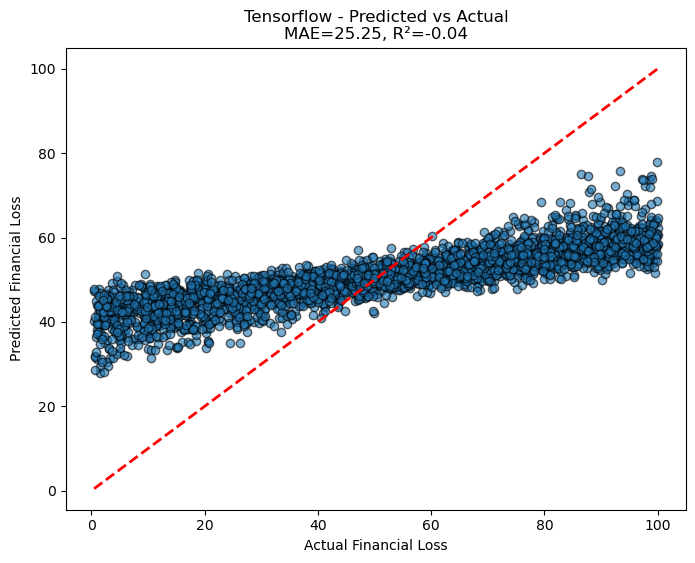

In [61]:
#Utility
def build_tf_model(input_dim):
    model = models.Sequential([layers.Dense(64, activation="relu", input_shape=(input_dim,)), layers.Dense(32, activation="relu"), layers.Dense(1)])
    model.compile(optimizer=optimizers.Adam(), loss="mae")
    return model

#Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
tf_mae_scores, tf_r2_scores = [], []

for train_idx, test_idx in kf.split(X):
    # Split raw
    X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx].values, y.iloc[test_idx].values

    # Fit preprocessor only on training data
    X_train_cv = preprocessor.fit_transform(X_train_raw)
    X_test_cv = preprocessor.transform(X_test_raw)

    if hasattr(X_train_cv, "toarray"):  # convert sparse to dense
        X_train_cv = X_train_cv.toarray()
        X_test_cv = X_test_cv.toarray()

    X_train_cv = X_train_cv.astype(np.float32)
    X_test_cv = X_test_cv.astype(np.float32)

    # Build + train model fresh per fold
    model = build_tf_model(X_train_cv.shape[1])
    model.fit(X_train_cv, y_train_cv, epochs=20, batch_size=32, verbose=0)

    # Predict & evaluate
    y_pred_cv = model.predict(X_test_cv, verbose=0).flatten()
    mae, r2 = evaluate_model(y_test_cv, y_pred_cv)
    tf_mae_scores.append(mae)
    tf_r2_scores.append(r2)

#Average metrics
tf_mae = np.mean(tf_mae_scores)
tf_r2 = np.mean(tf_r2_scores)

#Final model trained on all data
X_full = preprocessor.fit_transform(X)
if hasattr(X_full, "toarray"):
    X_full = X_full.toarray()
X_full = X_full.astype(np.float32)

final_tf_model = build_tf_model(X_full.shape[1])
history = final_tf_model.fit(X_full, y.values, epochs=20, batch_size=32, verbose=0, validation_split=0.2)  # hold-out validation for plotting)

#Predictions on full data
y_pred_tf = final_tf_model.predict(X_full, verbose=0).flatten()

#Predicted vs Actual
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_sk, alpha=0.6, edgecolor="k")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)  #ideal line
plt.xlabel("Actual Financial Loss")
plt.ylabel("Predicted Financial Loss")
plt.title(f"Tensorflow - Predicted vs Actual\nMAE={tf_mae:.2f}, R²={tf_r2:.2f}")
plt.show()

## PyTorch

#### PyTorch uses a feed-forward neural network with two hidden layers to process the information, providing a MAE of 25.19 and an R-Squared value of -0.03.

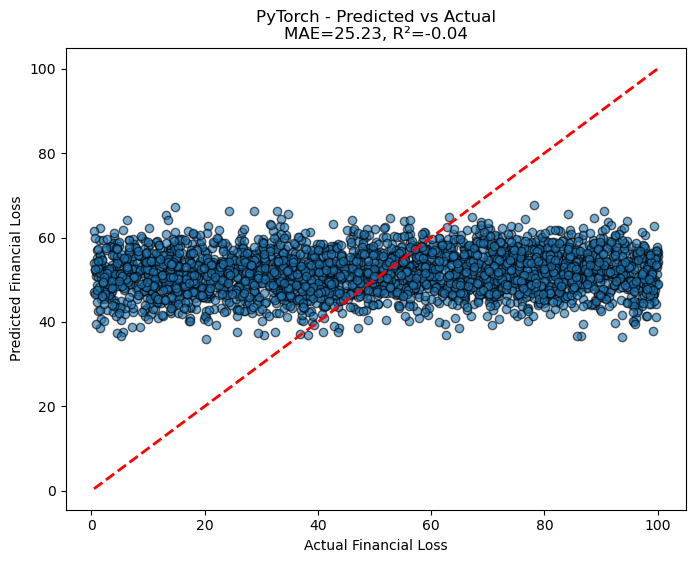

In [64]:
# Utility function
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, r2

# Define PyTorch Model
class PTModel(nn.Module):
    def __init__(self, input_dim):
        super(PTModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Cross-validation (with preprocessing inside loop)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
pt_mae_scores, pt_r2_scores = [], []

for train_idx, test_idx in kf.split(X):
    # Split raw data
    X_train_raw, X_test_raw = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y.iloc[train_idx].values, y.iloc[test_idx].values

    # Fit preprocessor only on training data
    X_train_cv = preprocessor.fit_transform(X_train_raw)
    X_test_cv = preprocessor.transform(X_test_raw)

    # Convert sparse to dense if needed
    if hasattr(X_train_cv, "toarray"):
        X_train_cv = X_train_cv.toarray()
        X_test_cv = X_test_cv.toarray()

    # Convert to float32
    X_train_cv = X_train_cv.astype(np.float32)
    X_test_cv = X_test_cv.astype(np.float32)

    # Convert to torch tensors
    X_train_tensor = torch.tensor(X_train_cv, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_cv, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_cv, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_cv, dtype=torch.float32).view(-1, 1)

    #Define model/optimizer/criterion per fold
    model = PTModel(X_train_cv.shape[1])
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    #Training loop
    for epoch in range(20):
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    #Evaluate on test fold
    y_pred_cv = model(X_test_tensor).detach().numpy().flatten()
    mae, r2 = evaluate_model(y_test_cv, y_pred_cv)
    pt_mae_scores.append(mae)
    pt_r2_scores.append(r2)

#Mean scores across folds
pt_mae = np.mean(pt_mae_scores)
pt_r2 = np.mean(pt_r2_scores)

#Train final model on *all* data with preprocessing
X_full = preprocessor.fit_transform(X)
if hasattr(X_full, "toarray"):
    X_full = X_full.toarray()
X_full = X_full.astype(np.float32)

X_tensor = torch.tensor(X_full, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

model = PTModel(X_full.shape[1])
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

for epoch in range(20):
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

#Predictions on full set
y_pred_pt = model(X_tensor).detach().numpy().flatten()

#Predicted vs Actual Plot
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_pt, alpha=0.6, edgecolor="k")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
plt.xlabel("Actual Financial Loss")
plt.ylabel("Predicted Financial Loss")
plt.title(f"PyTorch - Predicted vs Actual\nMAE={pt_mae:.2f}, R²={pt_r2:.2f}")
plt.show()

## XGBoost

#### XGBoost uses gradient-boosted decision trees to process the information, providing a MAE of 21.96 and an R-Squared value of 0.22.

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found: {'model__subsample': 0.8, 'model__n_estimators': 100, 'model__max_depth': 8, 'model__learning_rate': 0.01, 'model__colsample_bytree': 1.0}
Mean Absolute Error: 21.9608
R² Score: 0.2184


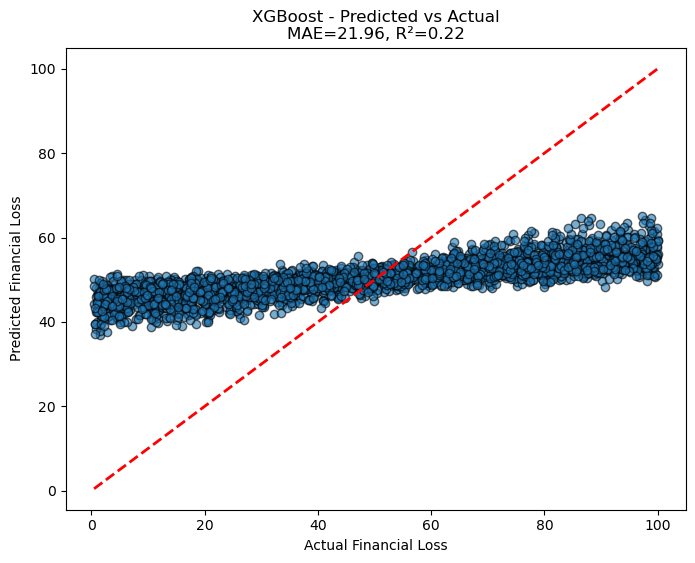

In [67]:
#Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

#Preprocessing pipeline
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_cols), ('cat', categorical_transformer, categorical_cols)])

#Define model and pipeline - - Numeric: impute missing with median, then scale, Categorical: impute missing with most frequent, then one-hot encode
xgb_model = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

#Combine preprocessing for numeric + categorical into one ColumnTransformer
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', xgb_model)])

#Hyperparameter search
param_dist = {'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [3, 4, 5, 6, 8, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]}

#Setup cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#Randomized search over hyperparameters
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, scoring='neg_mean_absolute_error', cv=cv, verbose=2,
                                   random_state=42, n_jobs=-1)
random_search.fit(X, y)

print("Best parameters found:", random_search.best_params_)

#Evaluate best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X)

#Calculated MAE and R-2
xgb_mae = mean_absolute_error(y, y_pred)
xgb_r2 = r2_score(y, y_pred)

print(f"Mean Absolute Error: {xgb_mae:.4f}")
print(f"R² Score: {xgb_r2:.4f}")

# Scatterplot
plt.figure(figsize=(8,6))
plt.scatter(y, y_pred, alpha=0.6, edgecolor="k")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", lw=2)
plt.xlabel("Actual Financial Loss")
plt.ylabel("Predicted Financial Loss")
plt.title(f"XGBoost - Predicted vs Actual\nMAE={xgb_mae:.2f}, R²={xgb_r2:.2f}")
plt.show()

## Which model worked best?

#### As shown in the df below, Sci-Kit Learn and XGBoost were the only models that had a positive R-Squared score. Sci-Kit Learn, however, had both the lowest Mean Absolute Error and highest R-Squared value. As a result, this method was chosen for future examination.

In [70]:
#Converting the results to a dataframe.
results = [{"Model": "TensorFlow", "MAE": tf_mae, "R²": tf_r2},
    {"Model": "scikit-learn (RF)", "MAE": sk_mae, "R²": sk_r2},
    {"Model": "PyTorch", "MAE": pt_mae, "R²": pt_r2},
    {"Model": "XGBoost (Baseline)", "MAE": xgb_mae, "R²": xgb_r2}]

results_df = pd.DataFrame(results)
results_df

,Model,MAE,R²
0,TensorFlow,25.249577,-0.037879
1,scikit-learn (RF),20.023870,0.349296
2,PyTorch,25.231680,-0.035686
3,XGBoost (Baseline),21.960797,0.218428


## Hyperparameter search through Scikit Learn

#### Of 20 potential candidates, 8 was chosen as the best fit as it had the lowest MAE. It neither under-fit nor over-fit the data compared to the others.

In [73]:
#Splits the dataset into 5 folds.
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#Defines the hyperparameters for XGBoost to tune to.
param_dist = {'model__n_estimators': [100, 200, 300, 500],
    'model__max_depth': [3, 4, 5, 6, 8, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]}

#Aapplies preprocessing (scaling, one-hot encoding), training the model to avoid data leakage.
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', xgb_model)])

#Tries different combinations and selects the lowest error.
random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_dist, n_iter=20, scoring='neg_mean_absolute_error', cv=cv,
                                   verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X, y)
best_model = random_search.best_estimator_

print(best_model)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Year',
                                                   'Number of Affected Users',
                                                   'Incident Resolution Time '
                                                   '(in Hours)']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(str

# Visualization and Feature Identification

#### The following were seen as key factors in leading to higher financial loss during a cyber attack incident:


**Number of Affected Users** - More users impacted leads to higher financial loss.  
**Incident Resolution Time** - Longer time to resolve an incident increases financial loss.  
**Year** - More recent years correspond with higher losses (breaches have become costlier over time).  
**Industry** - Incidents in the *Education* sector were among the highest risk in this dataset.  
**Attack Source** - Insider attacks are more costly than typical external attacks.  
**Attack Type** - Certain attacks, such as DDoS or Ransomware, tend to drive higher losses.

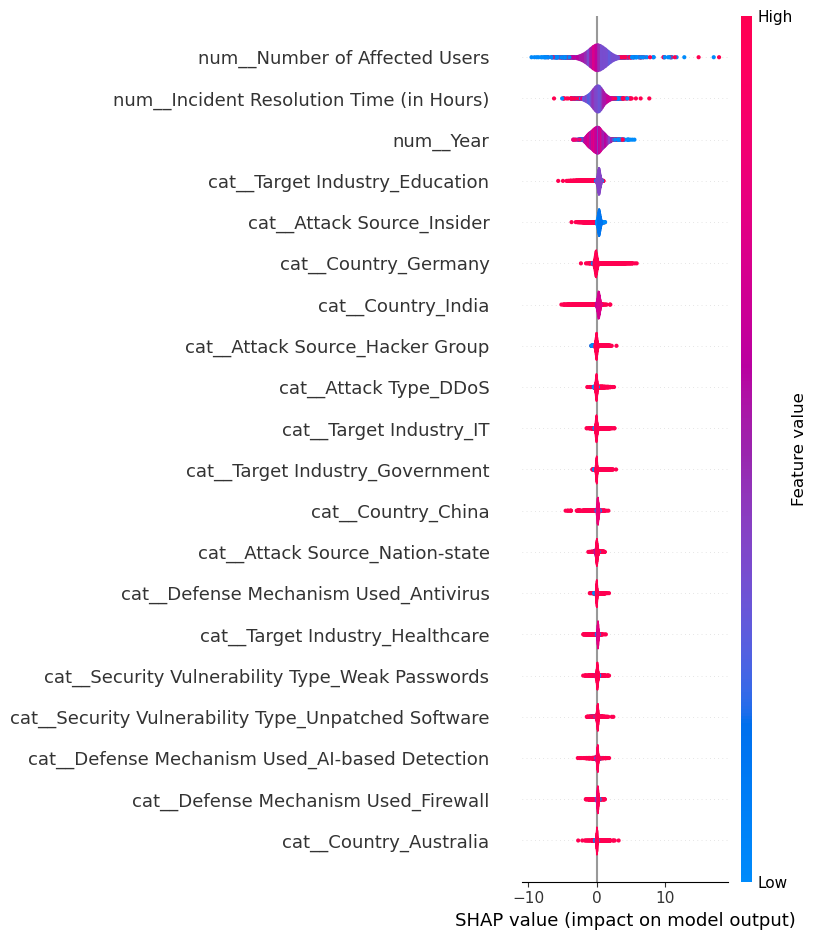

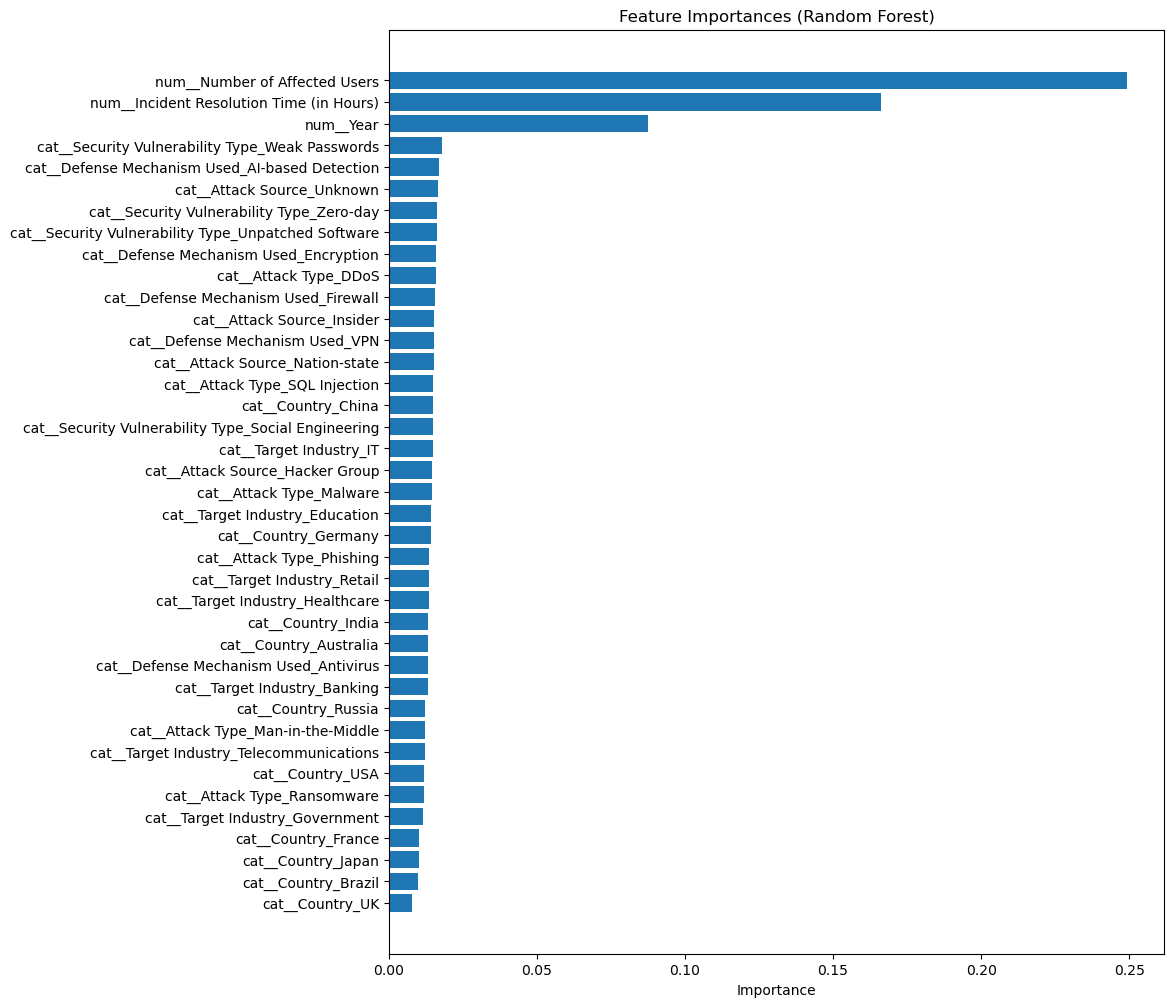

In [76]:
#Preprocess X for SHAP
X_transformed = best_sk_model.named_steps["preprocessor"].transform(X)

#Ensure dense array if sparse
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

#Ensure numeric dtype
X_transformed = X_transformed.astype(np.float32)

#Get feature names
feature_names = best_sk_model.named_steps["preprocessor"].get_feature_names_out()

#Extract feature importances from Random Forest
importances = best_sk_model.named_steps["model"].feature_importances_
feat_df = pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values(by="Importance", ascending=False)

#TreeExplainer for RF
explainer = shap.TreeExplainer(best_sk_model.named_steps["model"])
shap_values = explainer.shap_values(X_transformed)

#Standardized violin plot
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, plot_type="violin")

#Plot
plt.figure(figsize=(10, 12))
plt.barh(feat_df["Feature"], feat_df["Importance"])
plt.gca().invert_yaxis()  # highest importance at top
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

# Sample Prediction

#### This sample scenario, using the Sci-Kit Learn pipeline ML model assumes that there was a cyber attack incident in:

**Country** - Germany  
**Year** - 2025  
**Attack Type** - DDoS  
**Target Industry** - Education  
**Attack Source** - Insider  
**Security Vulnerability Type** - Weak Passwords  
**Defense Mechanism Used** - None  
**Incident Resolution Time** - 200 Hours  
**Number of Affected Users** - One million people  

In this scenario, this model predicts that the cyber attack incident will cost just over $52 million.

In [79]:
#Sample prediction
sample = pd.DataFrame([{
    'Country': 'Germany',                        
    'Year': 2025,                                
    'Attack Type': 'DDoS',                       
    'Target Industry': 'Education',              
    'Attack Source': 'Insider',                  
    'Security Vulnerability Type': 'Weak Passwords',  
    'Defense Mechanism Used': 'None',            
    'Incident Resolution Time (in Hours)': 200,  
    'Number of Affected Users': 1000000}])

#Makes prediction with your tuned RF pipeline
prediction = best_model.predict(sample)

print("Predicted Financial Loss (original scale):", prediction[0])
print("Predicted Financial Loss (log scale):", np.log1p(prediction[0]))

Predicted Financial Loss (original scale): 52.220844
Predicted Financial Loss (log scale): 3.97445
